<a href="https://colab.research.google.com/github/imranajec/gemini-langchain-product-info-retrieval/blob/main/gemini_langchain_product_info_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Install dependencies
!pip install transformers langchain faiss-cpu requests pillow matplotlib

In [35]:
!pip install docarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 4.7 MB/s eta 0:00:00


In [23]:
!pip install langchain-google-genai

In [30]:
# Import necessary libraries
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.vectorstores import DocArrayInMemorySearch
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import Document
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter



In [31]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [42]:
def load_model(model_name):
    if model_name == "gemini-pro":
        llm = ChatGoogleGenerativeAI(model="gemini-pro")
    else:
        llm = ChatGoogleGenerativeAI(model="gemini-pro-vision")
    return llm

def get_image(filepath):
    image = Image.open(filepath)
    image.show()
    return image

def get_text_chunks_langchain(text):
    text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = [Document(page_content=x) for x in text_splitter.split_text(text)]
    return docs


In [32]:
# Load models
llm_text = load_model("gemini-pro")
llm_vision = load_model("gemini-pro-vision")


In [33]:
# Load and process text data
loader = TextLoader("/content/Timoboll alc.txt")
text = loader.load()[0].page_content
docs = get_text_chunks_langchain(text)


In [36]:
# Generate text chunks and embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectorstore = DocArrayInMemorySearch.from_documents(docs, embedding=embeddings)
retriever = vectorstore.as_retriever()

/usr/local/lib/python3.10/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [38]:
# Handle text query
query = "is the blade good for attacking, give me a yes or no?"
relevant_docs_text = retriever.invoke(query)

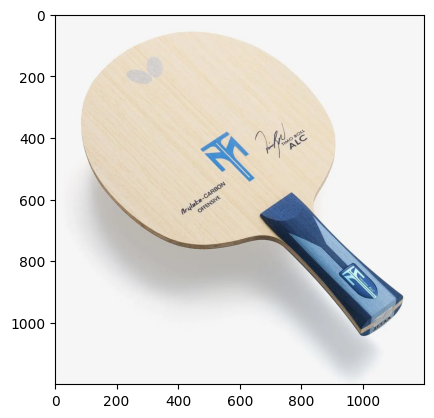

In [43]:
image_filepath = "/content/35861_01.jpg"
image = get_image(image_filepath)
plt.imshow(image)
plt.show()

In [44]:
image_analysis_result = llm_vision.invoke([
    HumanMessage(content=[
        {"type": "text", "text": "Describe the product in this image."},
        {"type": "image_url", "image_url": image_filepath}  # Update to use local image path
    ])
]).content

In [45]:
# Perform similarity search with image description
relevant_docs_image = retriever.invoke(image_analysis_result)


In [54]:
# Combine results
combined_context = "\n".join([doc.page_content for doc in relevant_docs_text + relevant_docs_image])
combined_prompt = f"""
{combined_context}

Image Analysis Result:
{image_analysis_result}

{query}

Provide me the answer according to the query.
"""

message = HumanMessage(content=combined_prompt)

# Generate response
result = llm_text.invoke([message])
# Display the response content
display(Markdown(result.content))


Yes, the blade is good for attacking because it is an offensive blade, which means that it is designed for players who want to hit the ball with a lot of power.